In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from keras import layers
from keras import models
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

# This tokenizer is nice, but could cause problems.
try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

%matplotlib inline

# Parameters

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# Data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# Encoded Tokens
preprocessed_corpus_path = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed.p')

indices_test_path = os.path.join(
    nlp_repo, 'data/03_processed/indices_test_path.p')

# Training parameters
train_anyway = False
model_path = "product_descr.h5"
#dataset_size = 500
epochs = 10
batch_size = 128
hidden_size = 1000

# Turning the Encoded Sequences into a Tensorflow Dataset

In [3]:
test_descr.head()

,Text_ID,Product_Description,Product_Type
0,5786,RT @mention Going to #SXSW? The new iPhone gui...,7
1,5363,RT @mention 95% of iPhone and Droid apps have ...,9
2,6716,RT @mention Thank you to @mention for letting ...,9
3,4339,#Thanks @mention we're lovin' the @mention app...,7
4,66,At #sxsw? @mention / @mention wanna buy you a ...,9


In [4]:
indices_train, vocabulary = pd.read_pickle(preprocessed_corpus_path)

In [5]:
indices_test, _ = pd.read_pickle(indices_test_path)

Sources:
* TF dataset: https://stackoverflow.com/questions/58362316/how-do-i-go-from-pandas-dataframe-to-tensorflow-batchdataset-for-nlp

In [6]:
train_descr_original = tf.keras.preprocessing.sequence.pad_sequences(
    indices_train, padding='post', value=len(vocabulary))
train_labels_original = train_descr['Sentiment'].to_numpy().flatten()

In [7]:
test_descr_original = tf.keras.preprocessing.sequence.pad_sequences(
    indices_test, padding='post', value=len(vocabulary))
# test_labels_original = test_descr['Sentiment'].to_numpy().flatten() #not given in the Test.csv

In [8]:
print(train_descr_original)
print(train_descr_original.shape)
print(train_labels_original)
print(test_descr_original)

[[ 154 3719  294 ... 7119 7119 7119]
 [   4    1   24 ... 7119 7119 7119]
 [ 451    6   22 ... 7119 7119 7119]
 ...
 [   4    1    4 ... 7119 7119 7119]
 [ 204  256   16 ... 7119 7119 7119]
 [   5   13 7118 ... 7119 7119 7119]]
(6364, 25)
[2 2 2 ... 2 2 2]
[[   4    1   21 ... 7119 7119 7119]
 [   4    1    7 ... 7119 7119 7119]
 [   4    1   73 ... 7119 7119 7119]
 ...
 [  64    5  184 ... 7119 7119 7119]
 [   4    1    0 ... 7119 7119 7119]
 [ 190    5   92 ... 7119 7119 7119]]


#### Train & Validation Split

In [9]:
split_index = int(0.8 * len(train_descr_original))

In [10]:
train_ds_original = tf.data.Dataset.from_tensor_slices(
    (train_descr_original[:split_index], train_labels_original[:split_index])).cache()

In [11]:
validation_ds_original = tf.data.Dataset.from_tensor_slices(
    (train_descr_original[split_index:], train_labels_original[split_index:])).cache()

In [12]:
# test_ds_original = tf.data.Dataset.from_tensor_slices(
#    (test_descr_original[split_index:], test_labels_original[split_index:])).cache()

#### Transformation

#### Check, if transformation went ok

In [13]:
train_test_descr, train_test_label = list(train_ds_original.take(1))[0]

In [14]:
train_test_descr.numpy()

array([ 154, 3719,  294,  450,   17,   11,   18,    1,    2,    0, 7119,
       7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119,
       7119, 7119, 7119], dtype=int32)

In [15]:
train_test_label.numpy()  # .reshape(-1,).shape

2

In [16]:
# ToDo: import from utils

In [17]:
def decode_indices(indices, vocabulary):
    """ Decodes a sequence of indices and returns a string. """
    # adding an extra item for padding in order to keep the decoding correct after padding
    # if we use the default value 0 for padding, it would be translated to one of our tokens
    vocabulary.append('padding')
    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

In [18]:
decoded_train_test_descr = decode_indices(train_test_descr, vocabulary)
decoded_train_test_descr

'web designeruas guide ios android app today mention link sxsw padding padding padding padding padding padding padding padding padding padding padding padding padding padding padding'

In [19]:
#test_test_descr = list(test_ds_original.take(1))[0]
#decoded_test_test_descr = decode_indices(test_test_descr, vocabulary)
# decoded_test_test_descr

# Bag-of-Words

* Bag-of-words will be used as a baseline model. 
* Its advantages are that it is fairly easy and quick to build. 
* The downside is that bag-of-words does not perserve the order of the sentence. As a result the structure of a sentence is lost. 
* RNNs & 1D ConvNets will be tried later in order to remedy this.

### One Hot Encoding

In [20]:
dimensions_descr = len(vocabulary)
dimensions_labels = len(set(train_descr['Sentiment']))


def one_hot_encode(indices, labels):
    indices = tf.dtypes.cast(indices, tf.int32)
    descr_encoded = tf.one_hot(indices=indices, depth=dimensions_descr)
    # takes the maximum in order to create one element
    descr_encoded = tf.reduce_max(descr_encoded, 0)

    label_encoded = tf.one_hot(indices=labels, depth=dimensions_labels)
    return descr_encoded, label_encoded

Compare before and after one-hot-encoding

In [21]:
random_descr_orig, random_label_orig = list(train_ds_original.take(1))[0]
print(random_descr_orig.shape)
print(random_descr_orig.numpy())
print(np.sum(random_descr_orig))
print(random_label_orig.numpy())

(25,)
[ 154 3719  294  450   17   11   18    1    2    0 7119 7119 7119 7119
 7119 7119 7119 7119 7119 7119 7119 7119 7119 7119 7119]
111451
2


In [22]:
train_ds = train_ds_original.map(
    lambda descr, label: one_hot_encode(descr, label)).cache()

validation_ds = validation_ds_original.map(
    lambda descr, label: one_hot_encode(descr, label)).cache()

# test_ds = test_ds_original.map(
#    lambda descr, label: one_hot_encode(descr, label)).cache()

In [23]:
len(vocabulary)

7120

In [24]:
test_l = list(train_ds.take(1))[0][1]
test_l

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>

In [25]:
random_descr, random_label = list(train_ds.take(1))[0]
print(random_descr.shape)
print(random_descr.numpy())
print(np.sum(random_descr))
print(random_label)
print(random_label.shape)

(7120,)
[1. 1. 1. ... 0. 0. 1.]
11.0
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
(4,)


In [26]:
random_descr_val, random_label_val = list(validation_ds.take(1))[0]
print(random_descr_val.shape)
print(random_descr_val.numpy())
print(np.sum(random_descr_val))
print(random_label_val)

(7120,)
[1. 1. 0. ... 0. 0. 1.]
16.0
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


# Fully Connected NN & Bag of Words

In [27]:
model = models.Sequential()

model.add(layers.Dense(16, activation='relu',
                       input_shape=(dimensions_descr, )))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                113936    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 114,276
Trainable params: 114,276
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(
    train_ds.batch(32),
    epochs=20,
    validation_data=validation_ds.batch(32)
)

Epoch 1/20
160/160 [==============================] - 1s 7ms/step - loss: 1.2218 - accuracy: 0.5160 - val_loss: 1.0277 - val_accuracy: 0.5766
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 1.0577 - accuracy: 0.5728 - val_loss: 0.9499 - val_accuracy: 0.5766
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9844 - accuracy: 0.5918 - val_loss: 0.9227 - val_accuracy: 0.5766
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9485 - accuracy: 0.5940 - val_loss: 0.9092 - val_accuracy: 0.5766
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.9319 - accuracy: 0.5950 - val_loss: 0.9016 - val_accuracy: 0.5766
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.9188 - accuracy: 0.5944 - val_loss: 0.8952 - val_accuracy: 0.5766
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.9052 - accuracy: 0.5948 - val_loss: 0.8865 - val_accuracy: 0.5766
Epoch 

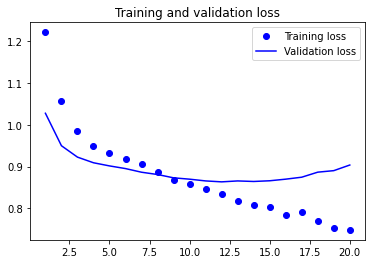

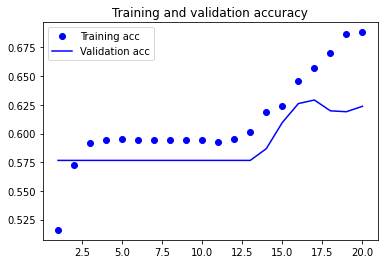

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Embeddings Layer

In [30]:
vocabulary_size = len(vocabulary)
embedding_size = 8
sequence_length = np.max([len(x) for x in indices_train])

In [47]:
model_emb = models.Sequential()

model_emb.add(layers.Embedding(vocabulary_size,
                               embedding_size, input_length=sequence_length))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(16, activation='relu'))
#model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(16, activation='relu'))
#model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(4, activation='softmax'))

model_emb.summary()

model_emb.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 8)             56960     
_________________________________________________________________
flatten_3 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
Total params: 60,516
Trainable params: 60,516
Non-trainable params: 0
_________________________________________________________________


In [48]:
history_emb = model_emb.fit(
    train_ds_original.batch(32), #! not the one-hot-encoded
    epochs=10,
    validation_data=validation_ds_original.batch(32)
)

Epoch 1/10


ValueError: in user code:

    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


In [49]:
loss_emb = history_emb.history['loss']
val_loss_emb = history_emb.history['val_loss']
acc_emb = history_emb.history['accuracy']
val_acc_emb = history_emb.history['val_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_emb, 'bo', label='Training loss')
plt.plot(epochs, val_loss_emb, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc_emb, 'bo', label='Training acc')
plt.plot(epochs, val_acc_emb, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

NameError: name 'history_emb' is not defined

# LSTM

# 1D Convolutional NN